**TCC BI 2019_4**

# **Identificação de documentos do tipo certidão de óbito e nascimento através de um classificador baseado em rede neural convolucional.**<br>

Aplicação de Classificador Supervisionado baseado em Rede Pré-treinada Convolucional , Rede Full Conected e uso de técnicas de Transfer Learning e Data Augmentation.<br>

Marcio Martins R Ramos



**Instalação de pacotes de software python necessários.**

In [ ]:
!apt-get install poppler-utils
!pip install pdf2image
!pip install Pillow
!pip install opencv-python

<br>
<br>

**Importando bibliotecas.**

In [ ]:
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import glob
from imutils import paths

import PIL
from PIL import ImageEnhance, ImageFilter, Image

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.callbacks import TensorBoard

from pdf2image import convert_from_path


<br>
<br>

## **Preparação dos dados**

A base de dados possui 119 arquivos de certidões de óbito e 103 arquivos de certidões de casamento no formato PDF (*Portable Document Format*). Faremos a conversão de PDF para imagem JPEG/JPG (*Joint Photographic Experts Group*) para cada arquivo . Para manter a uniformidade dos dados, utilizaremos o parãmetro *grayscale* no modo TRUE (ativado) da função *convert_from_path*, gerando todas as imagens em tons de cinza. Um tom de cinza é obtido quando os valores de vermelho, verde e azul do pixel são todos iguais, ou seja, a oscilação dos valores dos pixels é reduzida com
valores mais constantes.<br>

In [ ]:
# Cada arquivo em pdf da pasta obito será transformado em uma imagem jpg e armazenado na pasta obito_img

popler_path= r"C:\Program Files\poppler-0.68.0\bin" # caminho de "poppler" para processamento em máquina local

pdf_dir1 = "C:\Marcio\certidao_pdf\obito"
pdf_save1 = "C:\Marcio\certidao_imagem\obito_img"
os.chdir(pdf_dir1)

for pdf_file1 in os.listdir(pdf_dir1):

        if pdf_file1.endswith(".pdf"):

            pages = convert_from_path(pdf_file1, dpi=700,fmt="jpeg", grayscale=True, size = 1500, poppler_path=poppler_path)
            pdf_file1 = pdf_file1[:-4]

            for page in pages:
               os.chdir(pdf_save1)
               page.save("%s-page%d.jpg" % (pdf_file1,pages.index(page)), "JPEG")
               os.chdir(pdf_dir1)

In [ ]:
# Cada arquivo em pdf da pasta casamento será transformado em uma imagem jpg e armazenado na pasta casamento_img

pdf_dir2 = "C:\Marcio\certidao_pdf\casamento"
pdf_save2 = "C:\Marcio\certidao_imagem\casamento_img"
os.chdir(pdf_dir2)

for pdf_file2 in os.listdir(pdf_dir2):

        if pdf_file2.endswith(".pdf"):

            pages = convert_from_path(pdf_file2, dpi=700, fmt="jpeg", grayscale=True, size = 1500, poppler_path=poppler_path)
            pdf_file2 = pdf_file2[:-4]

            for page in pages:
               os.chdir(pdf_save2)
               page.save("%s-page%d.jpg" % (pdf_file2,pages.index(page)), "JPEG")
               os.chdir(pdf_dir2)

<br>
<br>

**Explorando as caracteristicas das imagens.**

In [ ]:
# Carregando exemplos de imagem jpg 

imagem = Image.open  ("C:\Marcio\certidao_imagem\casamento_img\casamento1-page0.jpg")

# Sumarizando detalhes sobre a imagem
# Modo da imagem
print(imagem.mode)
# Formato da imagem
print(imagem.format)
# Tamanho da imagem (largura, altura)
print(imagem.size)

RGB
JPEG
(1061, 1500)


<br>
<br>

**As imagens utilizadas para treinar a rede foram sem desfoque, porém as imagens abaixo apresentadas foram propositalmente desfocadas para proteger conteúdo de dados pessoais nesta publicação.**

**CERTIDÃO DE ÓBITO:**

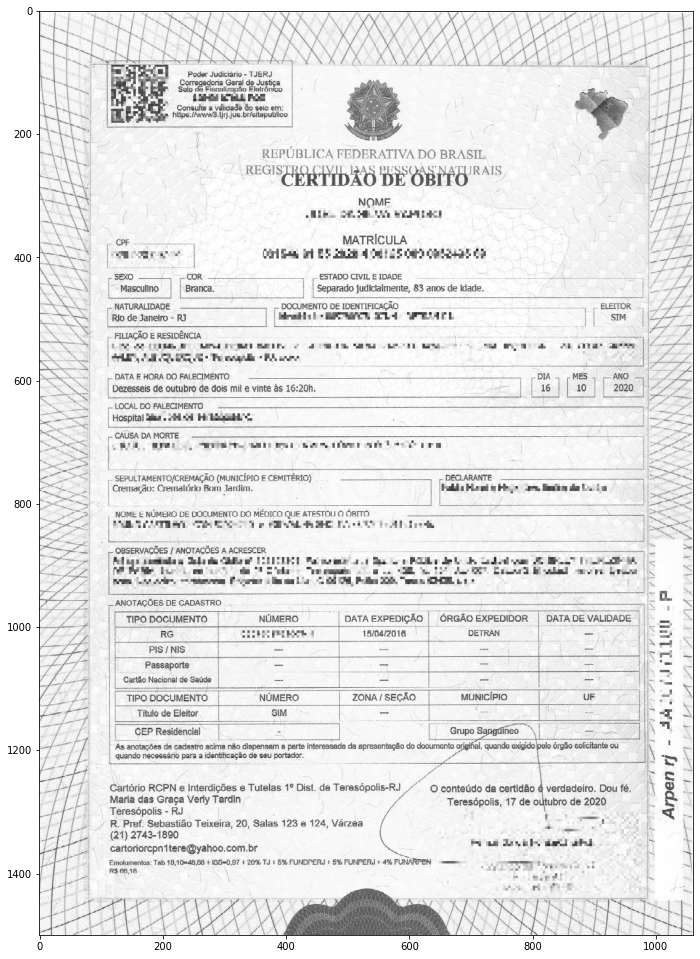

In [ ]:
filename = "C:\Marcio\certidao_imagem\obito_img\obito110-page0.jpg"
img = plt.imread(filename)
plt.figure(figsize=(17, 17))
plt.imshow(img)
plt.show()

**CERTIDÃO DE CASAMENTO:**

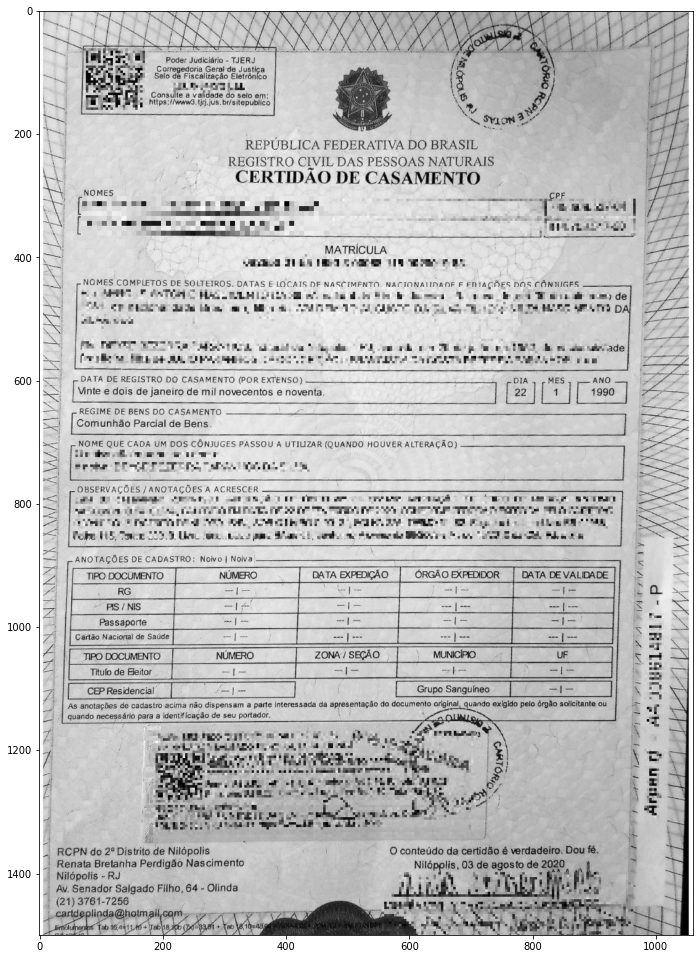

In [ ]:
filename = "C:\Marcio\certidao_imagem\casamento_img\casamento102-page0.jpg"
img = plt.imread(filename)
plt.figure(figsize=(17, 17))
plt.imshow(img)
plt.show()

<br>

**Organizando as imagens na lista *data* e os rótulos obito_img e casamento_img  na lista *labels*. Obtemos então uma lista com 228 imagens e seus rótulos.**

In [ ]:
# Definir o caminho das imagens e gerar listas vazias de "data" e "labels"

dataset_path = "C:\Marcio\certidao_imagem"
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []

[INFO] loading images...


In [ ]:
# Percorrer os caminhos das imagens, extrair o nome da pasta para utilizá-lo no rótulo (label: obito e casamento)

for imagePath in imagePaths:
    # Extrair o rótulo da classe do nome do arquivo
    label = imagePath.split(os.path.sep)[-2]
    
   # Carregar a imagem, trocar os canais de cores e redimensionar para ser um 500x750 píxeles sem levar em conta a proporção da imagem
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (500, 750))
    
    # Atualizar as listas de dados e rótulos, respectivamente
    data.append(image)
    labels.append(label)
print("labels: ", np.unique(labels))

labels:  ['casamento_img' 'obito_img']


In [ ]:
# Converter dados e rótulos em matrizes NumPy enquanto dimensiona pixel na faixa [0, 255]

data = np.array(data) / 255.0
labels = np.array(labels)

In [ ]:
len(data) , len(labels)

(222, 222)

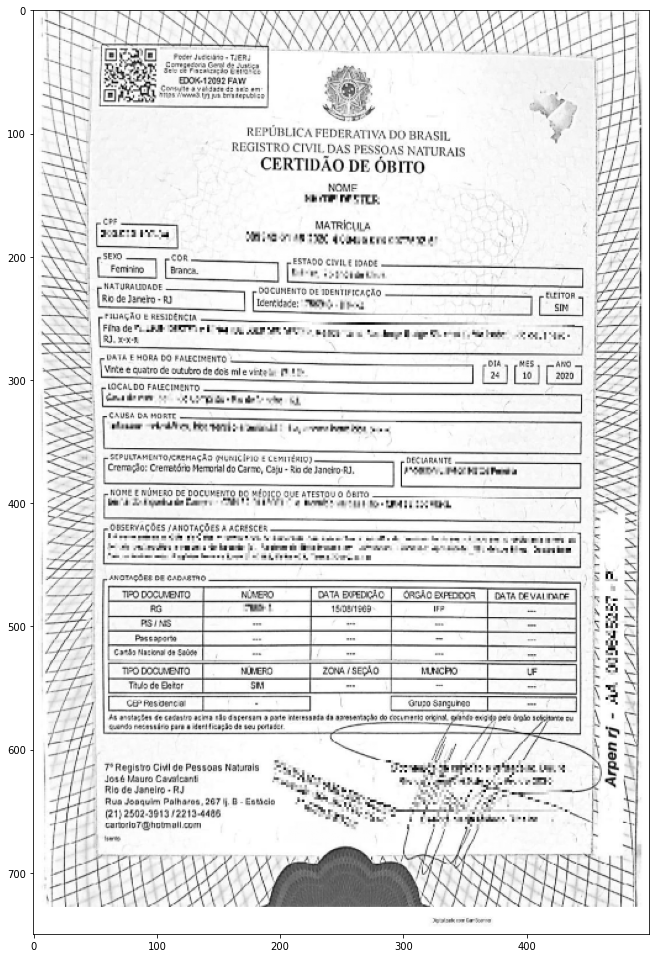

In [ ]:
plt.figure(figsize=(17, 17))
plt.imshow(data[labels=='obito_img'][116])
plt.show()

<br>
<br>

**Abaixo são apresentadas 2 amostras de certidão de óbito e 2 amostras de certidão de casamento.**

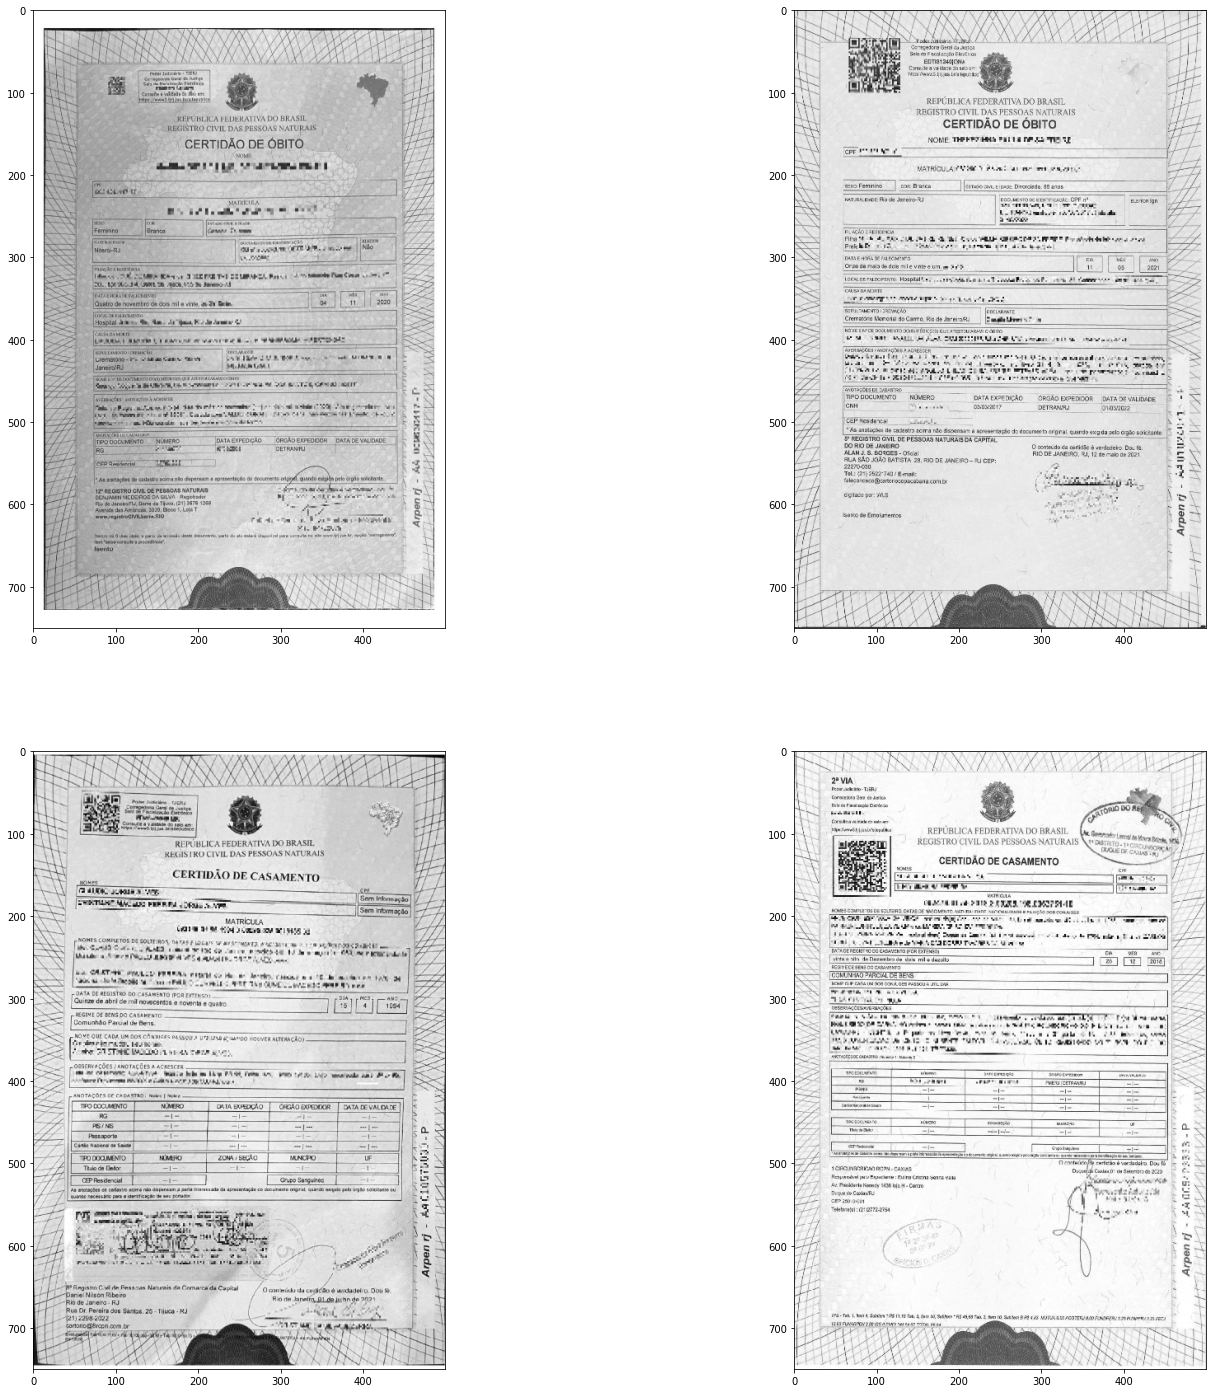

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(25, 25))
axs[0, 0].imshow(data[labels=='obito_img'][117])
axs[0, 1].imshow(data[labels=='obito_img'][118])
axs[1, 0].imshow(data[labels=='casamento_img'][102])
axs[1, 1].imshow(data[labels=='casamento_img'][101])
plt.show()

In [ ]:
# Realizar codificação one-hot nos rótulos, "1" representa "obito" e "0" representa "casamento"

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

<br>
<br>

**Definimos a taxa de aprendizado (learning rate), o número de épocas e o *Batch Size*.**

In [ ]:
INIT_LR = 1e-4  # taxa de aprendizado
EPOCHS = 50 # Epocas
BS = 8  # Batch Size

<br>
<br>

**Separamos a base em treino e teste. A base de teste será 30% da base de teste.** 

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.25, stratify=labels, random_state=42)

<br>
<br>

**A base de teste possui 159 registros e a base de teste possui 69 registros**

In [ ]:
trainX.shape , trainY.shape , testX.shape , testY.shape

((166, 750, 500, 3), (166, 2), (56, 750, 500, 3), (56, 2))

<br>
<br>

## **Data Augmentation**

<br>
Como possuimos uma base pequena de aproximadamente 200 registros e tendo em vista que estamos utilizando uma rede profunda (deep learning), aplicamos a técnica de Data Augmentation para aumentar a quantidade e variabilidade da base de dados. Com isso podemos melhorar o resultado do classificador de documentos no formato imagens. Neste caso específico, o aumento da rotação irá girar aleatoriamente a imagem até um determinado número de graus. Aqui, vamos definir para 15.

In [ ]:
# Iniciar a técnica de augmentation para ser utilizada nos dados de treinamento
trainAug = ImageDataGenerator(
    rotation_range=15)

<br>
<br>

## **Transfer** **Learning**

Utilizaremos o conhecimento adquirido por uma rede pré-treinada com uma determinada base dados para resolver o problema proposto de identificação de documentos. Com isso, a tarefa de aprendizado da rede convolucional não parte do zero, mas sim de um conhecimento prévio. No caso em questão de reconhecimento de imagem, aproveitamos principalmente o aprendizado das primeiras camadas da rede pré-treinada responsável por detectar características genéricas.     

Construimos o modelo baseado em uma rede VGG16 (Visual Geometry Group) pré-treinada com dataset *Imagenet*. Esta arquitetura VGG16 apresenta 16 camadas, sendo constituídas por *convolutional* *layers*, *max* *pooling* *layers*, *activation* *layers* e
*fully* *connected* *layers*. Ao todo há 13 camadas de convolução, 5 camadas de max pooling e 3 camadas densas.
<br>
Utilizaremos os pesos da rede convolucional pré treinada. Desconectamos a rede densa pois construiremos uma nova rede densa com 64 neurônios na camada intermediaria e 2 neurônios na camada de saida, ja que temos 2 rótulos na base de dados. Aplicaremos também as técnicas de *pooling* e *dropout*.

In [ ]:
# Carregar VGG16, certificando-se de que os conjuntos de camadas principais do FC permanecem desligados (off)

baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(750, 500, 3)))

# Construir a rede FC (Full Conected) que será inserida no topo do "base model"

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Inserir a rede FC no topo do "base model" (este modelo será treinado)

model = Model(inputs=baseModel.input, outputs=headModel)

# Fazer um loop sobre todas as camadas do modelo básico e congelá-las para que sejam atualizadas
# durante o primeiro processo de treinamento

for layer in baseModel.layers:
    layer.trainable = False

# Compilar o modelo

print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])
;

[INFO] compiling model...


''

<br>
<br>

**Resumo do modelo:**<br>
**Observamos todas as camadas de nossa rede usando o método** ***summary***.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 750, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 187, 125, 128)     0     

<br>
<br>

**Treinamento da rede Full Conected e aplicação da técnica de Data Augmentation.**  

In [ ]:
# Treinar a rede 

print("[INFO] training head...")
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/50
20/20 [==============================] - 88s 2s/step - loss: 0.7548 - accuracy: 0.5223 - val_loss: 0.6603 - val_accuracy: 0.6964
Epoch 2/50
20/20 [==============================] - 30s 1s/step - loss: 0.6717 - accuracy: 0.5987 - val_loss: 0.6255 - val_accuracy: 0.8571
Epoch 3/50
20/20 [==============================] - 30s 1s/step - loss: 0.6336 - accuracy: 0.6879 - val_loss: 0.5823 - val_accuracy: 0.9286
Epoch 4/50
20/20 [==============================] - 25s 1s/step - loss: 0.5817 - accuracy: 0.7006 - val_loss: 0.5470 - val_accuracy: 0.9464
Epoch 5/50
20/20 [==============================] - 30s 1s/step - loss: 0.5376 - accuracy: 0.8188 - val_loss: 0.5189 - val_accuracy: 0.9464
Epoch 6/50
20/20 [==============================] - 25s 1s/step - loss: 0.5256 - accuracy: 0.8280 - val_loss: 0.4948 - val_accuracy: 0.9464
Epoch 7/50
20/20 [==============================] - 29s 1s/step - loss: 0.4916 - accuracy: 0.8217 - val_loss: 0.4783 - val_accuracy: 0.8

<br>
<br>

## **Resultados do treinamento e inferência na rede treinada**

In [ ]:
# Realizar as predições dos dados de teste

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# Para cada imagem de teste será necessário encontrar o index do label (rótulo) que corresponde  
# a maior probablidade prevista

predIdxs = np.argmax(predIdxs, axis=1)

# Mostrar o relatório
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

# calcular a matriz de confusão e usá-la para derivar a acurácia

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total


# Mostrar a matriz de confusão e acurácia
print(cm)
print("acc: {:.4f}".format(acc))



[INFO] evaluating network...
               precision    recall  f1-score   support

casamento_img       0.93      0.96      0.94        26
    obito_img       0.97      0.93      0.95        30

     accuracy                           0.95        56
    macro avg       0.95      0.95      0.95        56
 weighted avg       0.95      0.95      0.95        56

[[25  1]
 [ 2 28]]
acc: 0.9464


Text(0.5, 1.0, 'Train - Accuracy')

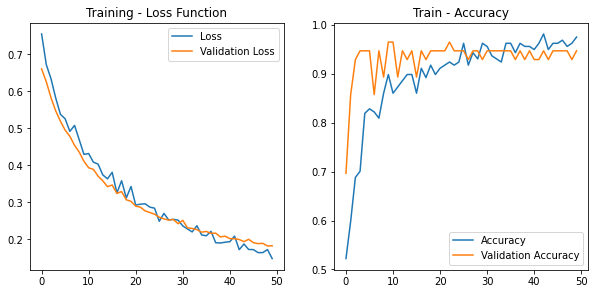

In [ ]:
# Plotar gráfico de Erro (Loss) e Acurácia para base de treino e validação 

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(H.history['loss'], label='Loss')
plt.plot(H.history ['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(H.history['accuracy'], label='Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

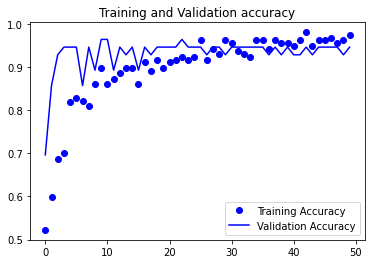

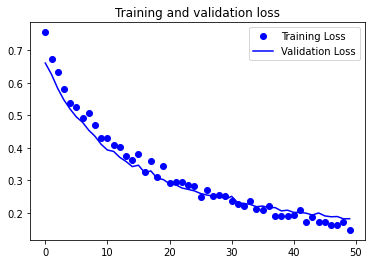

In [ ]:
#Visualização de outra forma dos resultados

import matplotlib.pyplot as plt
%matplotlib inline
accuracy = H.history['accuracy']
val_accuracy = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Predição de uma imagem

predictions = model.predict(testX)
predictions[1]

array([0.73767185, 0.26232815], dtype=float32)

In [ ]:
# Como "1" representa obito e "0" casamento, a predição resultou coretamente em certidão de casamento".
np.argmax(predictions[1])

0

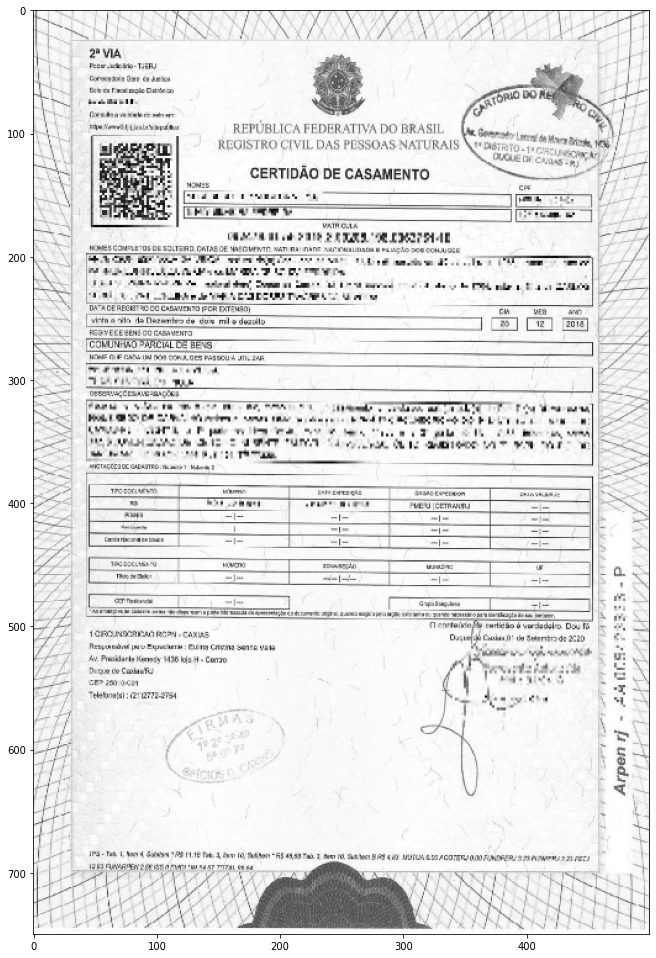

In [ ]:
plt.figure(figsize=(17, 17))
plt.imshow(testX[1])
plt.show()